In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# Pyspark - SQL
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import mean, col, split, regexp_extract, when, lit

# Pyspark - ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

### 데이터 로드

- Pyspark에서 데이터 로드할 때는 ``os.chdir()``로 디렉토리명 바꾸어도 적용이 안됨!

In [3]:
spark = SparkSession.builder\
        .appName('Play with pypsark ML on Titanic Data')\
        .getOrCreate()

df = spark.read.csv('/Users/younghun/Desktop/gitrepo/data/titanic/train.csv', header=True, inferSchema=True)

In [4]:
# toPandas()를 이용해 판다스에서 제공하는 데이터프레임 형태로 출력
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [5]:
# 데이터 스키마 살펴보기
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



### 데이터 시각화
- Matplotlib, Seaborn 등을 이용하려면 ``SparkDataFrame``➡️``PandasDataFrame``으로 변경해주고 수행해야 함!

In [6]:
pandas_df = df.toPandas()
print("pandas_df 타입:", type(pandas_df))

pandas_df 타입: <class 'pandas.core.frame.DataFrame'>


/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


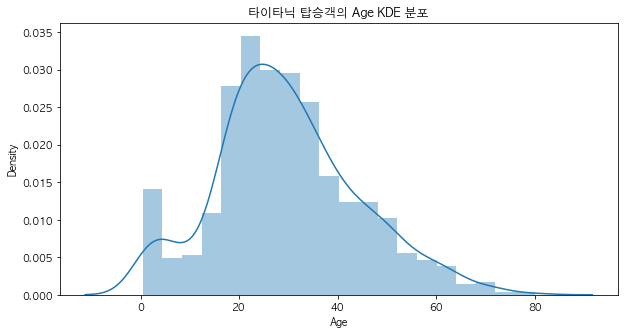

In [7]:
# Seaborn 사용해보기
plt.figure(figsize=(10, 5))
plt.title("타이타닉 탑승객의 Age KDE 분포")
sns.distplot(pandas_df['Age'])
plt.show()

### Pyspark에서 결측치 체크하기

- 결측치 체크하는 방법
    * 1. ``isnan()``: ``pyspark.sql.functions`` 패키지에 속함
        * ``isnan(column)``: 결측치가 존재하는 변수인지 체크하기 위함
    * 2. ``isNull()``: ``pyspark.sql.Column`` 패키지에 속함
        * ``isNull()``은 아무런 변수 넣지 않음
<br><br>
- ``when(조건, 조건 True시 value출력).otherwise(앞의 조건 False시 value출력)``
    * 조건에 여러 조건을 달려면 논리연산자 ``|``, ``&`` 사용 가능

In [8]:
# 위 2가지 방법을 동시에 사용해보자!
# 결측치가 있는 변수를 체크하고 결측치가 몇 개 있는지 살펴보기
from pyspark.sql.functions import isnan, count

# [count~] 부분은 list comprehension이면서 select([column]) 부분임!
# [count(~~) 변수를 'c'라는 변수로 alias하는 것임!] 
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])\
  .show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



- 변수 삭제하는 법
    * ``df.drop('column')`` 단, inplace=False이기 때문에 재할당 해주어야 함!

In [9]:
# Cabin 변수는 결측치가 50%가 넘기 때문에 해당 변수를 삭제하자
df = df.drop('Cabin')

- 연령의 결측치 대체하기
- 그런데, 승객들의 이름 앞에 ``Mr, Mrs``와 같은 salutation들이 존재하므로 이것을 기준으로 분할하고 각각의 평균값을 결측치 대체값으로 넣어주기
- Pyspark에서 제공하는 정규표현식 API 이용
    * ``regexp_extract(col('칼럼'), "정규표현식",

In [10]:
df = df.withColumn("Initial", regexp_extract(col("Name"),
                                            "([A-Za-z]+)\.", # ()이게 하나의 그룹임!
                                            1)) # 그룹 인덱스는 1부터!
df.limit(3).show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|Initial|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|     Mr|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|    Mrs|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|   Miss|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+



- 오탈자 대체하기
    * ``df.replace([오탈자], [수정된 글자])``

- ``collect()``: 적은 양의 데이터셋을 retrieve할 때!(큰 데이터셋은 메모리 에러 발생). ``select()``와 유사한 기능
    * 보통 ``filter()``, ``group()``, ``count()`` 후 사용
    * ``collect()``로 아무것도 넣지않으면 데이터프레임의 모든 row를 반환
    * 하지만 dataframe형태로 반환하지 않음. , pyspark Row타입의 데이터가 담긴 list를 반환하는데 이를 loop 사용가능함!

In [11]:
df = df.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

# Initial 변수 값들로 그룹핑한 후 평균 Age 구하기
df.groupby('Initial').avg('Age').collect()

[Row(Initial='Miss', avg(Age)=21.86),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=32.73960880195599),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]

In [12]:
test = df.groupby('Initial').avg('Age').collect()
print(type(test), type(test[0]))

<class 'list'> <class 'pyspark.sql.types.Row'>


### Pyspark에서 결측치 대체
- 위에서 도출한 연령별 평균값을 대체하기

In [13]:
df = df.withColumn('Age',
                  when((df['Initial'] == 'Miss') & (df['Age'].isNull()),
                      22).otherwise(df['Age']))
df = df.withColumn('Age',
                  when((df['Initial'] == 'Other') & (df['Age'].isNull()),
                      46).otherwise(df['Age']))
df = df.withColumn('Age',
                  when((df['Initial'] == 'Master') & (df['Age'].isNull()),
                      5).otherwise(df['Age']))
df = df.withColumn('Age',
                  when((df['Initial'] == 'Mr') & (df['Age'].isNull()),
                      33).otherwise(df['Age']))
df = df.withColumn('Age',
                  when((df['Initial'] == 'Mrs') & (df['Age'].isNull()),
                      36).otherwise(df['Age']))

In [15]:
# Embarked 변수에도 결측치가 2개 있었는데 무엇인지 확인해보기
df.groupBy('Embarked').count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+



- PysparkDataFrame의 결측치 채우는 함수
    * ``df.na.fill({'column': 'value'})``

In [16]:
# Embarked의 결측치는 최빈값인 'S'로 대체해주기
df = df.na.fill({"Embarked": "S"})

In [17]:
df.groupBy('Embarked').count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|       C|  168|
|       S|  646|
+--------+-----+



In [21]:
# 결측치가 있는 변수가 있는지 재확인!
df.select([count(when(isnan(c) | df[c].isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|Initial|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|       0|      0|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+



### Feature Engineering
- Pyspark의 ``withColumn``, ``when ~ otherwise``주로 사용!
- 변수 추출하는 동일한 표현: ``df['SibSp'] = col('SibSp')``

In [23]:
# Family size라는 파생변수 생성
df = df.withColumn("Family_Size",
                  col('SibSp')+col('Parch')) # df['SibSp']도 가능!

# Alone이라는 Binary 파생변수 생성하는데, 우선 0으로 다 해놓기
df = df.withColumn('Alone', lit(0))
# 조건에 맞게 Alone 변수값 변경
df = df.withColumn('Alone',
                  when(col('Family_Size') == 0, 1)\
                  .otherwise(col('Alone')))

- 문자열로 이루어져있는 Sex, Embarked, Initial을 숫자로 바꾸어주기(일종의 **Label Encoding**)
    * ``StringIndexer(inputCol, outputCol)`` 사용!
    * ``fit(df)``한 객체에서 역으로 IndexToString 사용가능하니 fit, transform 따로 할당해주기!
    * ``transform(df)``

In [25]:
convert_cols = ['Sex', 'Embarked', 'Initial']

# 추후에 IndexToString할려면 indexer 객체를 사용하면 됨! 
indexer = [StringIndexer(inputCol=col,
                         outputCol=col+'_index').fit(df) for col in convert_cols]
print(indexer)
print(type(indexer))

[StringIndexerModel: uid=StringIndexer_93075463abbf, handleInvalid=error, StringIndexerModel: uid=StringIndexer_0bad941775a7, handleInvalid=error, StringIndexerModel: uid=StringIndexer_62d4a2f3326c, handleInvalid=error]
<class 'list'>


In [26]:
# Pipeline을 이용해 stage에다가 실행 과정 담아 넘기기
pipeline = Pipeline(stages=indexer)
df = pipeline.fit(df).transform(df)
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial,Family_Size,Alone,Sex_index,Embarked_index,Initial_index
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,1,0,0.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,1,0,1.0,1.0,2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,0,1,1.0,0.0,1.0


In [27]:
pandas_df = df.toPandas()
pandas_df['Initial_index'].value_counts()

0.0    529
1.0    186
2.0    127
3.0     40
4.0      9
Name: Initial_index, dtype: int64

- 모델링에 필요없는 변수들 삭제
    * 직접 변수들 정의하는 방식: ``df.drop('col1', 'col2', col3')
    * ``*``(unpacking)을 이용하는 방식도 존재!

In [36]:
un_cols = ["PassengerId","Name","Ticket","Cabin","Embarked","Sex","Initial"]

df = df.drop(*un_cols)
print("삭제 후 남은 칼럼들:", df.columns)

삭제 후 남은 칼럼들: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family_Size', 'Alone', 'Sex_index', 'Embarked_index', 'Initial_index']


### Convert all features to Vector

- ``VectorAssembler(inputCols, outputCol)``
    * ``StringIndexer``와는 달리 ``inputCol``에 ``s``가 붙어있음!
    * fit 존재하지 않고 바로 ``transform(df)`` 수행!

In [37]:
feature = VectorAssembler(inputCols = df.columns[1:],
                         outputCol='features')
feature_vector = feature.transform(df) # 데이터프레임 형태로 반환
print('feature type:', type(feature))
print('feature_vector type', type(feature_vector))

feature_vector.limit(3).toPandas()

feature type: <class 'pyspark.ml.feature.VectorAssembler'>
feature_vector type <class 'pyspark.sql.dataframe.DataFrame'>


,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,Alone,Sex_index,Embarked_index,Initial_index,features
0,0,3,22.0,1,0,7.2500,1,0,0.0,0.0,0.0,"(3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 0.0, 0.0, 0.0..."
1,1,1,38.0,1,0,71.2833,1,0,1.0,1.0,2.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 0.0, 1.0, ..."
2,1,3,26.0,0,0,7.9250,0,1,1.0,0.0,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 1.0, 0...."


### Split the datasets

- ``df.randomSplit([train_ratio, test_ratio])``
- split할 때는 ``VectorAssembler`` 시키기 이전의 다른 Raw 피처들도 함께 분할하긴 함. 하지만 **모델링 시 사용할 때는 벡터화 시킨 독립변수들과 종속변수만 사용!**

In [38]:
(train_df, test_df) = feature_vector.randomSplit([0.8, 0.2], seed=42)
train_df.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Family_Size: integer (nullable = true)
 |-- Alone: integer (nullable = false)
 |-- Sex_index: double (nullable = false)
 |-- Embarked_index: double (nullable = false)
 |-- Initial_index: double (nullable = false)
 |-- features: vector (nullable = true)



### Modeling

- 독립변수, 종속변수만 담은 데이터프레임 따로 추출 후 다시 split

In [39]:
titanic_df = feature_vector.select(['features', 'Survived'])

# split train, test
(train_df, test_df) = titanic_df.randomSplit([0.8, 0.2], seed=42)

#### Logistic Regression

In [41]:
# 분류 모델 
from pyspark.ml.classification import LogisticRegression
# 파라미터 튜닝 & 교차 검증
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.tuning import CrossValidator
# 파이프라인
from pyspark.ml import Pipeline
# 메트릭 얻는 라이브러리
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# ROC AUC(Sklearn)
from sklearn.metrics import roc_curve, auc


# 모델 정의
lr = LogisticRegression(labelCol='Survived')

# 튜닝할 파라미터 grid 정의
                                    # model.parameter 식으로 정의
paramGrid = ParamGridBuilder().addGrid(lr.regParam,
                                      (0.01, 0.1))\
                              .addGrid(lr.maxIter,
                                      (5, 10))\
                              .addGrid(lr.tol,
                                      (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam,
                                      (0.25, 0.75))\
                              .build()

# 교차검증 정의 - Pipeline식으로 정의
tvs = TrainValidationSplit(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='Survived'),
                          trainRatio=0.8)
# 학습은 fit으로!
model = tvs.fit(train_df)
# 평가는 transform으로!
model_prediction = model.transform(test_df)

# 메트릭 평가
print('Accuracy:',
     MulticlassClassificationEvaluator(labelCol='Survived',
                                      metricName='accuracy').evaluate(model_prediction))
print('Precision:',
     MulticlassClassificationEvaluator(labelCol='Survived',
                                      metricName='weightedPrecision').evaluate(model_prediction))

Accuracy: 0.7793103448275862
Precision: 0.7925739676458068
